# Yelp text data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import seaborn as sns
import dask.dataframe as dd
from dask import delayed
from dask_ml.model_selection import train_test_split
import spacy
import spacy_readability
from gensim.models import Word2Vec, Doc2Vec
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

sns.set_style('darkgrid')
laptop = '/media/seapea/Blade HDD/_Storage/Data/yelp_dataset/'
tower = '/run/media/seapea/HDD1TB_1/SharedSpace/_Large_datasets/Yelp/'
nlp = spacy.load('en_core_web_md')
# nlp = spacy.load('en_vectors_web_lg')
# nlp.add_pipe(nlp.create_pipe('sentencizer'))
# nlp.vocab.prune_vectors(300)
%matplotlib inline

In [4]:
# usr = dd.read_json('G:/SharedSpace/_Large_datasets/Yelp/user.json', lines=True, blocksize=2**28)
# biz = dd.read_json('E:/_Large_datasets/Yelp/business.json', lines=True)#, blocksize=2**28)

rev = dd.read_json('/run/media/seapea/HDD1TB_1/SharedSpace/_Large_datasets/Yelp/review.json', 
                   lines=True, blocksize=2**22) # lower blocksize (i.e. 2*22) made this work in Linux
rev = rev.drop(['funny', 'cool', 'date'], axis=1)
rev = rev.drop_duplicates(subset='text')
rev = rev.set_index('review_id')
rev.head()

# rev.to_parquet('/run/media/seapea/Blade HDD/_Storage/Data/yelp_dataset/parquet/')

,user_id,business_id,stars,useful,text
review_id,,,,,
----X0BIDP9tA49U3RvdSQ,gVmUR8rqUFdbSeZbsg6z_w,Ue6-WhXvI-_1xUIuapl0zQ,4,1,"Red, white and bleu salad was super yum and a ..."
---0hl58W-sjVTKi5LghGw,Y6qylbHq8QJmaCRSlKdIog,Ae4ABFarGMaI5lk1i98A0w,4,0,Ate the momos during the momo crawl.. Was the ...
---3OXpexMp0oAg77xWfYA,SnXZkRN9Yf060pNTk1HMDg,lKq4Qsz13FDcAVgp49uukQ,5,2,Pizza here made my night... Good people and gr...
---65iIIGzHj96QnOh89EQ,VcmSgvslHAhqWoEn16wjjw,6nKR80xEGHYf2UxAe_Cu_g,5,0,Great brisket sandwich as claimed. Weird that ...
---7WhU-FtzSUOje87Y4uw,NKF9v-r0jd1p0JVi9h2T1w,Z_mJYg3vi8cPZHa1J4BALw,5,1,"Interesting food, great atmosphere, and great ..."


#### Dask challenges
It has been very painful working with Dask. It is not covered in the course anywhere, despite being a more realistic work environment where too much data exists to analyze things in memory. Arithmetic computations and other analyses across the Dask dataframe chunks pose challenges we haven't seen when operating only in memory.

Some basic issues you can not run in Dask include:

- Boolean indexing
- spaCy pipelines (memory allocation)
- Word2Vec conversions (memory allocation)
- Basic computations (very long turn around)

Because of these limitations, some of the work and drudge behing the scenes might not be displayed in the notebook.

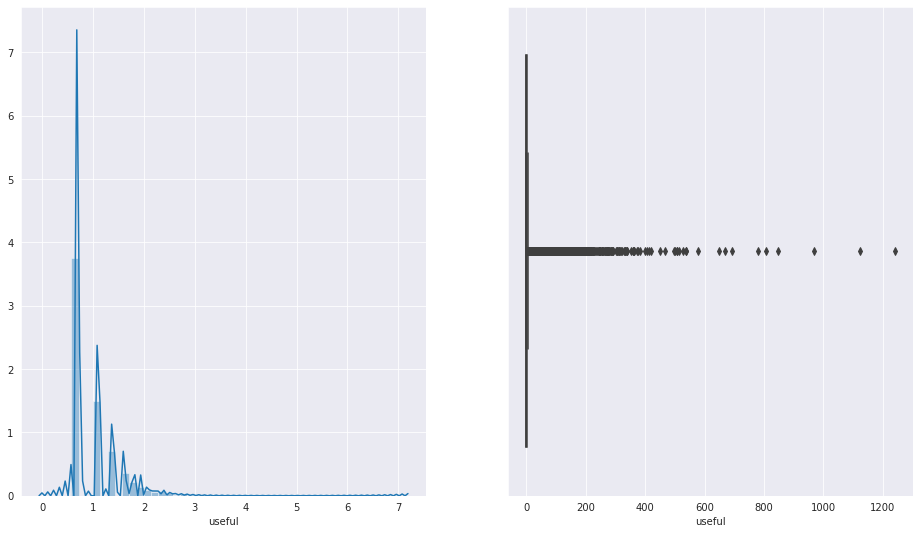

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,9))
sns.distplot(np.log((rev.useful + 2).compute()), ax=ax1)
sns.boxplot(rev.useful.compute(), ax=ax2)

In [51]:
rev[rev.useful == rev.useful.max().compute()].text.compute()

203142    Dinner for 1.\n\n- Preface\nI went to Amy's Ba...
Name: text, dtype: object

### Approaching parsing of vast text
We will first work with a simple approach - the CountVectorizer. Upon meddling in the data and trying different things, Dask and spaCy weren't able to execute necessary computations without more fiddling; we will return to those later. For now, we first build a delayed function for the Dask dataframe to pull the most frequent words from the corpus.

In [ ]:
@delayed
def ret_count(ddf):
    vec = CountVectorizer(stop_words='english', ngram_range=(1,2), max_features=30)
    X = vec.fit_transform(ddf)
    names = vec.get_feature_names()
    return X, names

ddf, names = ret_count(rev.text).compute()
print(names)

### Success! 
Our first tangible data to work with that didn't overload the system!

In [ ]:
def top4(val, ax):
    sns.distplot(ddf.todense()[:,val].reshape(1,-1), ax=ax)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16,9), sharex=True, sharey=True) 
axes = [ax1, ax2, ax3, ax4]

for val, ax in zip(range(4), axes):
    top4(val, ax)

### Previous attempts at spaCy
In a previous project, I limited my vocabulary and text subset to one million words as spaCy throws an error when too large a vocabulary exists for use in memory. I have since discovered a lazy computation design for this exists within spaCy called the pipe. This allows spaCy to batch the documents and prevent breaking memory constraints.

In [ ]:
rev.to_parquet(tower + 'parquet/')

In [4]:
df = pd.read_parquet(tower + 'parquet/part.0.parquet').set_index('review_id')
df.iloc[0]

user_id                                   hG7b0MtEbXx5QzbzE6C_VA
business_id                               ujmEBvifdJM6h6RLv4wQIg
stars                                                          1
useful                                                         6
funny                                                          1
cool                                                           0
text           Total bill for this horrible service? Over $8G...
date                                         2013-05-07 04:34:36
Name: Q1sbwvVQXV2734tPgoKj4Q, dtype: object

In [2]:
nlp.pipeline

[('tagger', <spacy.pipeline.pipes.Tagger at 0x7f72d9449518>),
 ('parser', <spacy.pipeline.pipes.DependencyParser at 0x7f72d83acf48>),
 ('ner', <spacy.pipeline.pipes.EntityRecognizer at 0x7f72d83acfa8>)]

In [3]:
doc = nlp.pipe(df.text.str.cat(sep=' ')[:1500])
list(doc)

NameError: name 'df' is not defined

In [52]:
doc_list = []
for sentence in doc.sents:
    app = [token.lemma_.lower() for token in sentence if not token.is_punct and not token.is_stop]
    doc_list.append(app)
    
# Word2Vec(doc_list[0])

AttributeError: 'generator' object has no attribute 'sents'

In [ ]:
for parq in os.listdir(path):
    df = pd.read_parquet(parq).set_index()
        for doc in nlp(df.text):
            